### TTV analysis assuming i.i.d. Gaussian noise

In [1]:
import os
os.nice(19)
os.environ["XLA_FLAGS"] = "--xla_cpu_use_thunk_runtime=false"

import jax
jax_version = jax.__version__
major, minor, patch = (int(x) for x in jax_version.split(".")[:3])
if (major, minor, patch) >= (0, 4, 32):
    print(f"JAX version: {jax_version}")
    os.environ["XLA_FLAGS"] = "--xla_cpu_use_thunk_runtime=false"
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from jax import config, random
import numpyro, jax
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 16
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

JAX version: 0.6.2
# jax device count: 16


In [2]:
from jnkepler.jaxttv import JaxTTV
from jnkepler.jaxttv.infer import ttv_default_parameter_bounds, ttv_optim_curve_fit, scale_pdic
from jnkepler.jaxttv.information import information
import arviz as az
import corner

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6)
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=False)

### define tcobs, errorobs, p_init
- lists of length = (# of planets)
- elements of tcobs and errorobs: arrays of transit times and errors for each planet
- elements of p_init: (reasonably) good guesses for planets' mean periods

In [4]:
d = pd.read_csv("ttv.txt", sep=",", header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(2)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(2)]
p_init = [6.398054024320285, 18.87916174274174] # rough initial guess
dt = 0.4
t_start, t_end = 1520., 3800.
jttv = JaxTTV(t_start, t_end, dt, tcobs, p_init, errorobs=errorobs, print_info=True)

# number of transiting planets:    2
# integration starts at:           1520.00
# first transit time in data:      1524.09
# last transit time in data:       3750.61
# integration ends at:             3800.00
# integration time step:           0.4000 (1/15 of innermost period)



/ut3/haru/miniconda2/envs/py3.10/lib/python3.10/site-packages/jnkepler/jaxttv/jaxttv.py:138: UserWarning: time step may be too large.
  warnings.warn("time step may be too large.")


### optimization

In [5]:
param_bounds = ttv_default_parameter_bounds(jttv)

# running least squares optimization...


/ut3/haru/miniconda2/envs/py3.10/lib/python3.10/site-packages/jnkepler/jaxttv/infer.py:124: UserWarning: Bounds for cosi/lnode not provided: assuming coplanar orbits.
  warnings.warn(


# objective function: 36236.62 --> 49.57 (47 data)
# elapsed time: 38.3 sec


/ut3/haru/miniconda2/envs/py3.10/lib/python3.10/site-packages/jnkepler/jaxttv/jaxttv.py:531: UserWarning: using t0 and P from a linear fit to the observed transit times.
  warnings.warn(


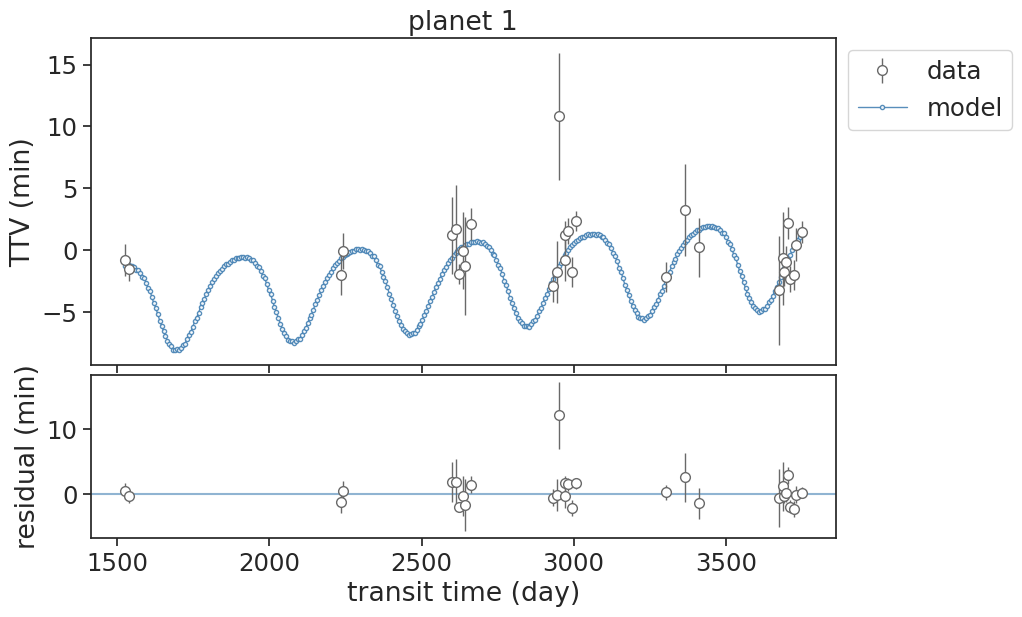

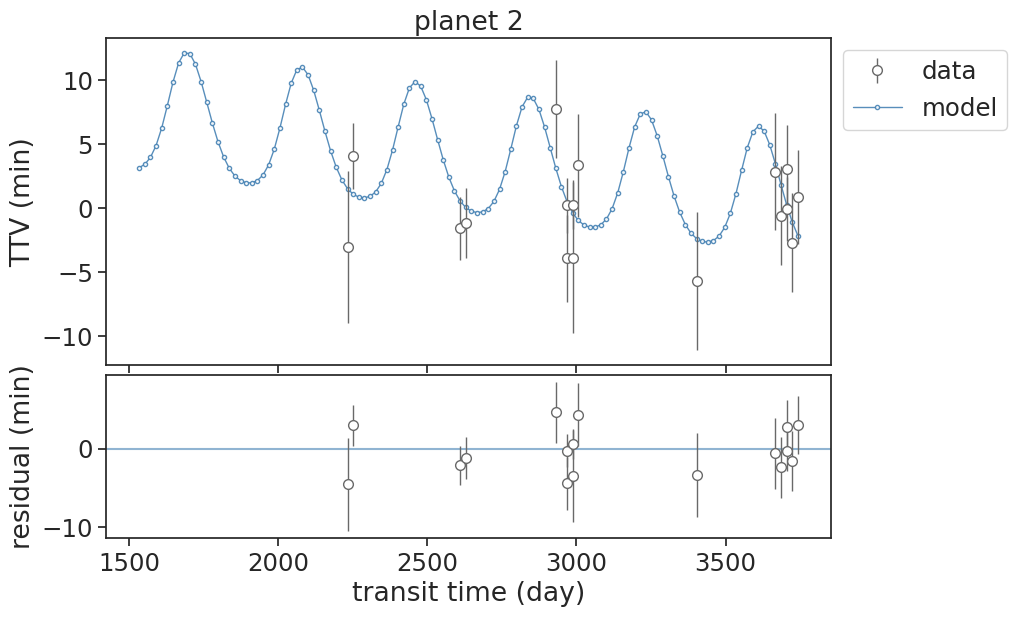

In [6]:
popt = ttv_optim_curve_fit(jttv, param_bounds)

### check precision & residual distribution

In [7]:
tc, tc_precise = jttv.check_timing_precision(popt)

# fractional energy error (symplectic, dt=4.00e-01): -1.79e-08
# fractional energy error (symplectic, dt=6.40e-03): -4.53e-12
# max difference in tc: 7.66e-05 days (6.61 sec)


sample: 100%|██████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 453.87it/s, 7 steps of size 4.03e-01. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      lndf      2.71      1.05      2.69      1.35      4.60     95.73      1.00
     lnvar     -0.12      0.30     -0.10     -0.56      0.36    120.21      1.01

Number of divergences: 0


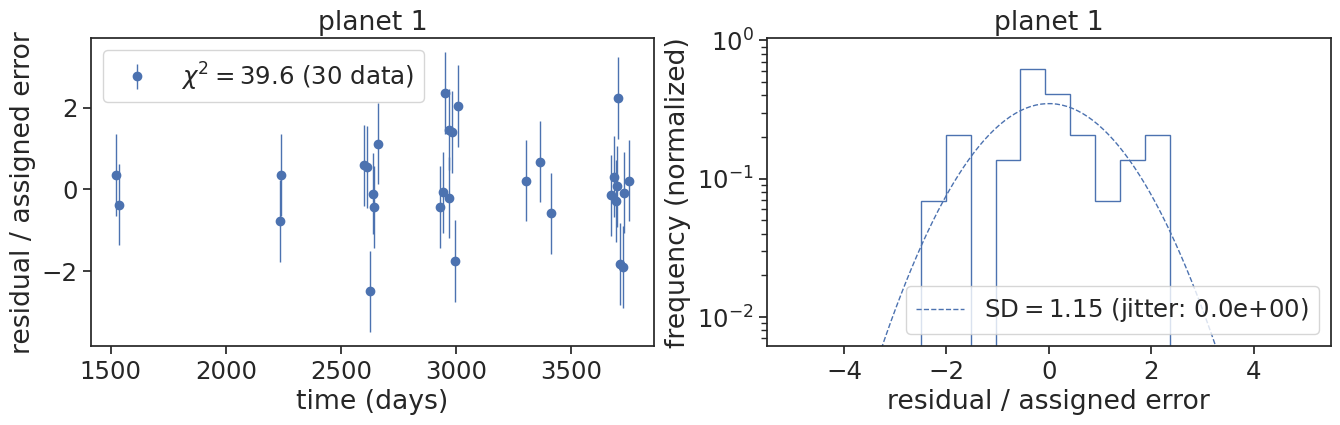

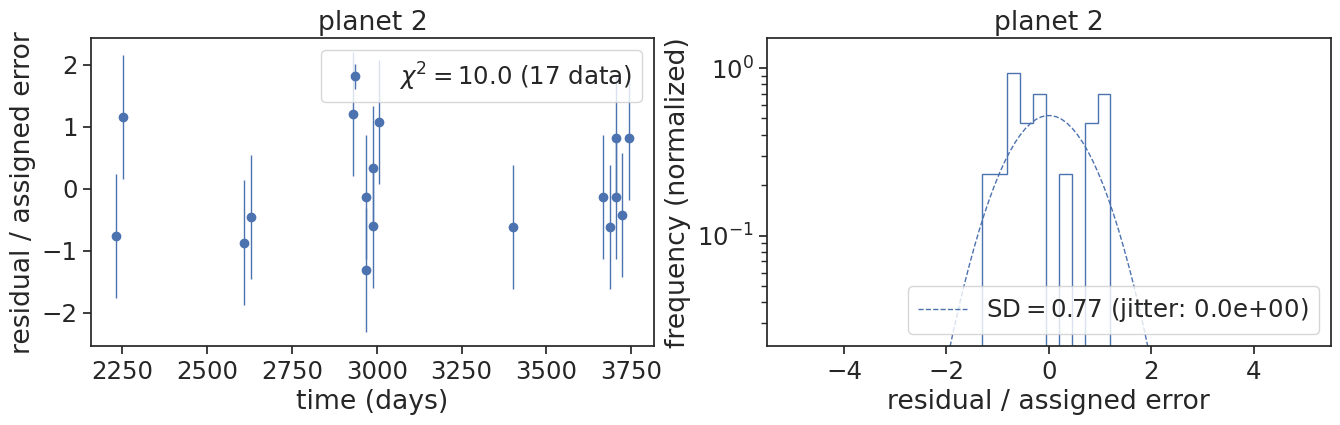

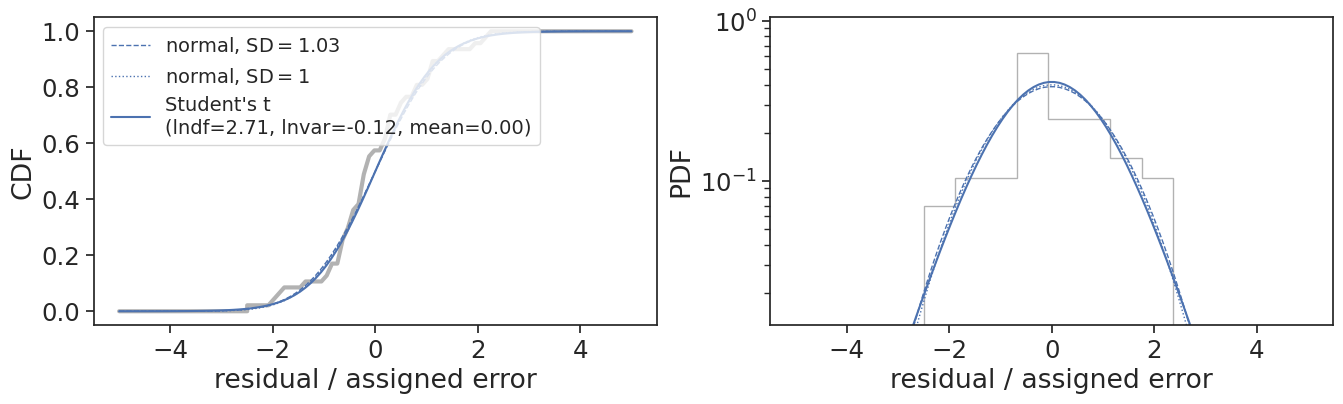

In [8]:
pdic_normal, pdic_student = jttv.check_residuals(popt)

### setup & run HMC

In [9]:
# いままではparamsの初期値たちの決め方と事前分布を自由に設定できた
# このコードは事前分布をupperとlowerと自動で決めた一様分布で、初期値たちは共通の最尤パラメータを用いている

def model_iid_normal(sample_keys, param_bounds, uniform_ecc=True, eps=1e-4):
    """numpyro model for scaled parameters"""
    par = {}

    # sample parameters from priors
    for key in sample_keys:
        par[key+"_scaled"] = numpyro.sample(key+"_scaled", dist.Uniform(param_bounds[key][0] * 0, param_bounds[key][0] * 0 + 1.))
        par[key] = numpyro.deterministic(key, par[key+"_scaled"] * (param_bounds[key][1] - param_bounds[key][0]) + param_bounds[key][0])
    if "pmass" not in sample_keys:
        par["pmass"] = numpyro.deterministic("pmass", jnp.exp(par["lnpmass"]))
    
    # Jacobian for uniform ecc prior
    # eps is introduced to prevent the log singularity at e=0; a smaller value can be used if needed
    if uniform_ecc:
        ecc = numpyro.deterministic("ecc", jnp.sqrt(par['ecosw']**2+par['esinw']**2))
        numpyro.factor("eprior", -jnp.log(ecc + eps))

    # compute transit times
    tcmodel, ediff = jttv.get_transit_times_obs(par)
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    
    # likelihood
    tcerrmodel = jttv.errorobs_flatten     
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [10]:
# physical parameters to sample from
sample_keys = ["ecosw", "esinw", "pmass", "period", "tic"]

In [11]:
# initialize inverse mass matrix using parameter covariance
# this part can be skipped; in that case just pass dense_mass=True in the next cell
pdic_scaled = scale_pdic(popt, param_bounds)
fisher_information_scaled = information(jttv, popt, sample_keys, param_bounds=param_bounds)
parameter_cov_scaled = jnp.linalg.inv(fisher_information_scaled)

dense_mass = [tuple([key+"_scaled" for key in sample_keys])]
inverse_mass_matrix = {dense_mass[0]: parameter_cov_scaled}

computing scaled information matrix.


In [12]:
kernel = NUTS(model_iid_normal, 
            init_strategy=init_to_value(values=pdic_scaled), 
            dense_mass=dense_mass,
            inverse_mass_matrix=inverse_mass_matrix,
            target_accept_prob=0.8,
            max_tree_depth=11
            )

In [13]:
mcmc = MCMC(kernel, num_warmup=2000, num_samples=2000, num_chains=num_chains)

In [14]:
# ~1hr
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sample_keys, param_bounds, extra_fields=('potential_energy', 'num_steps', 'adapt_state'))

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [15]:
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
 ecosw_scaled[0]      0.54      0.08      0.54      0.43      0.66    936.26      1.02
 ecosw_scaled[1]      0.51      0.07      0.50      0.39      0.62    727.12      1.03
 esinw_scaled[0]      0.55      0.08      0.55      0.44      0.67   1253.55      1.01
 esinw_scaled[1]      0.49      0.07      0.50      0.39      0.60   2102.55      1.01
period_scaled[0]      0.50      0.00      0.50      0.50      0.51    823.59      1.02
period_scaled[1]      0.50      0.00      0.50      0.50      0.51    420.63      1.04
 pmass_scaled[0]      0.26      0.22      0.20      0.00      0.59    850.82      1.02
 pmass_scaled[1]      0.29      0.15      0.28      0.05      0.51   1979.71      1.01
   tic_scaled[0]      0.50      0.00      0.50      0.50      0.50   1489.34      1.01
   tic_scaled[1]      0.62      0.11      0.59      0.48      0.81    421.58      1.04

Number of divergences: 2886


### save chains

In [16]:
idata = az.from_numpyro(mcmc)
idata.to_json("toi-560-251122.json")

'toi-560-251122.json'

### plot models drawn from posterior 

In [17]:
samples = mcmc.get_samples()

In [18]:
means, stds = jttv.sample_means_and_stds(samples)

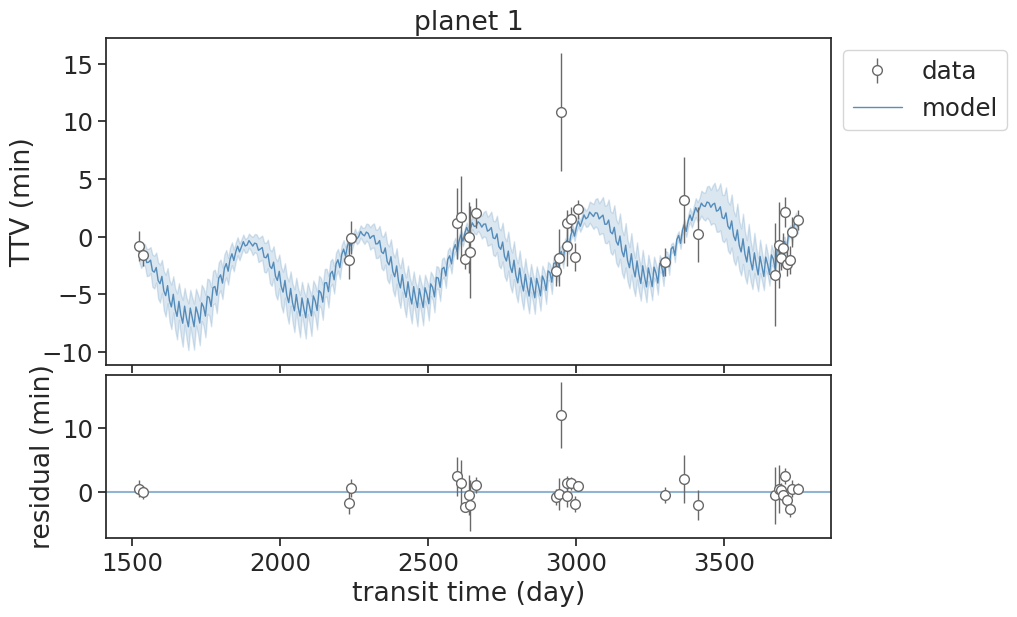

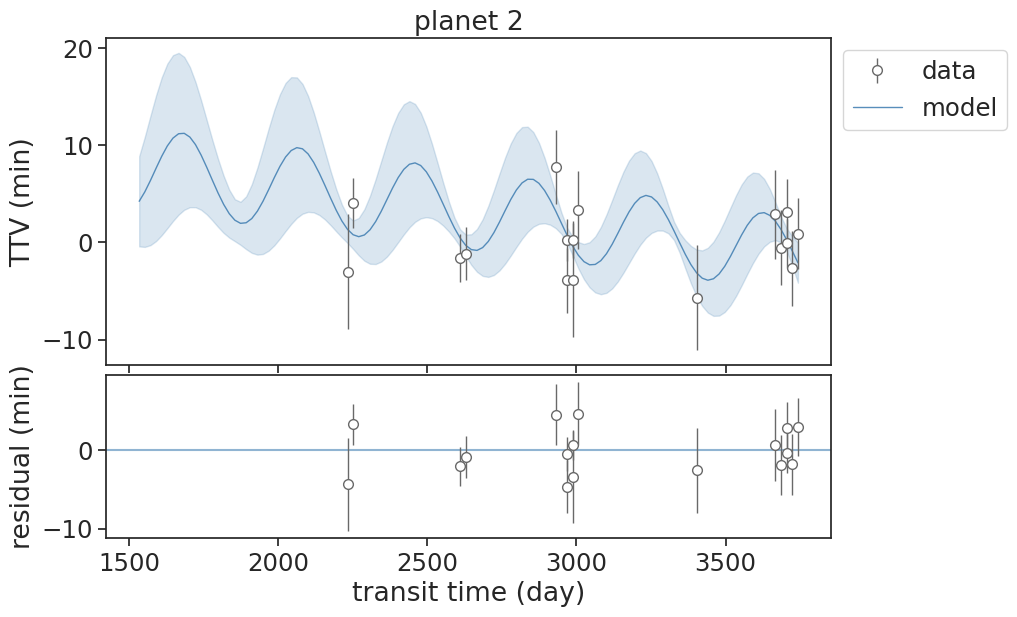

In [19]:
jttv.plot_model(means, tcmodelunclist=stds)

### trace and corner plots

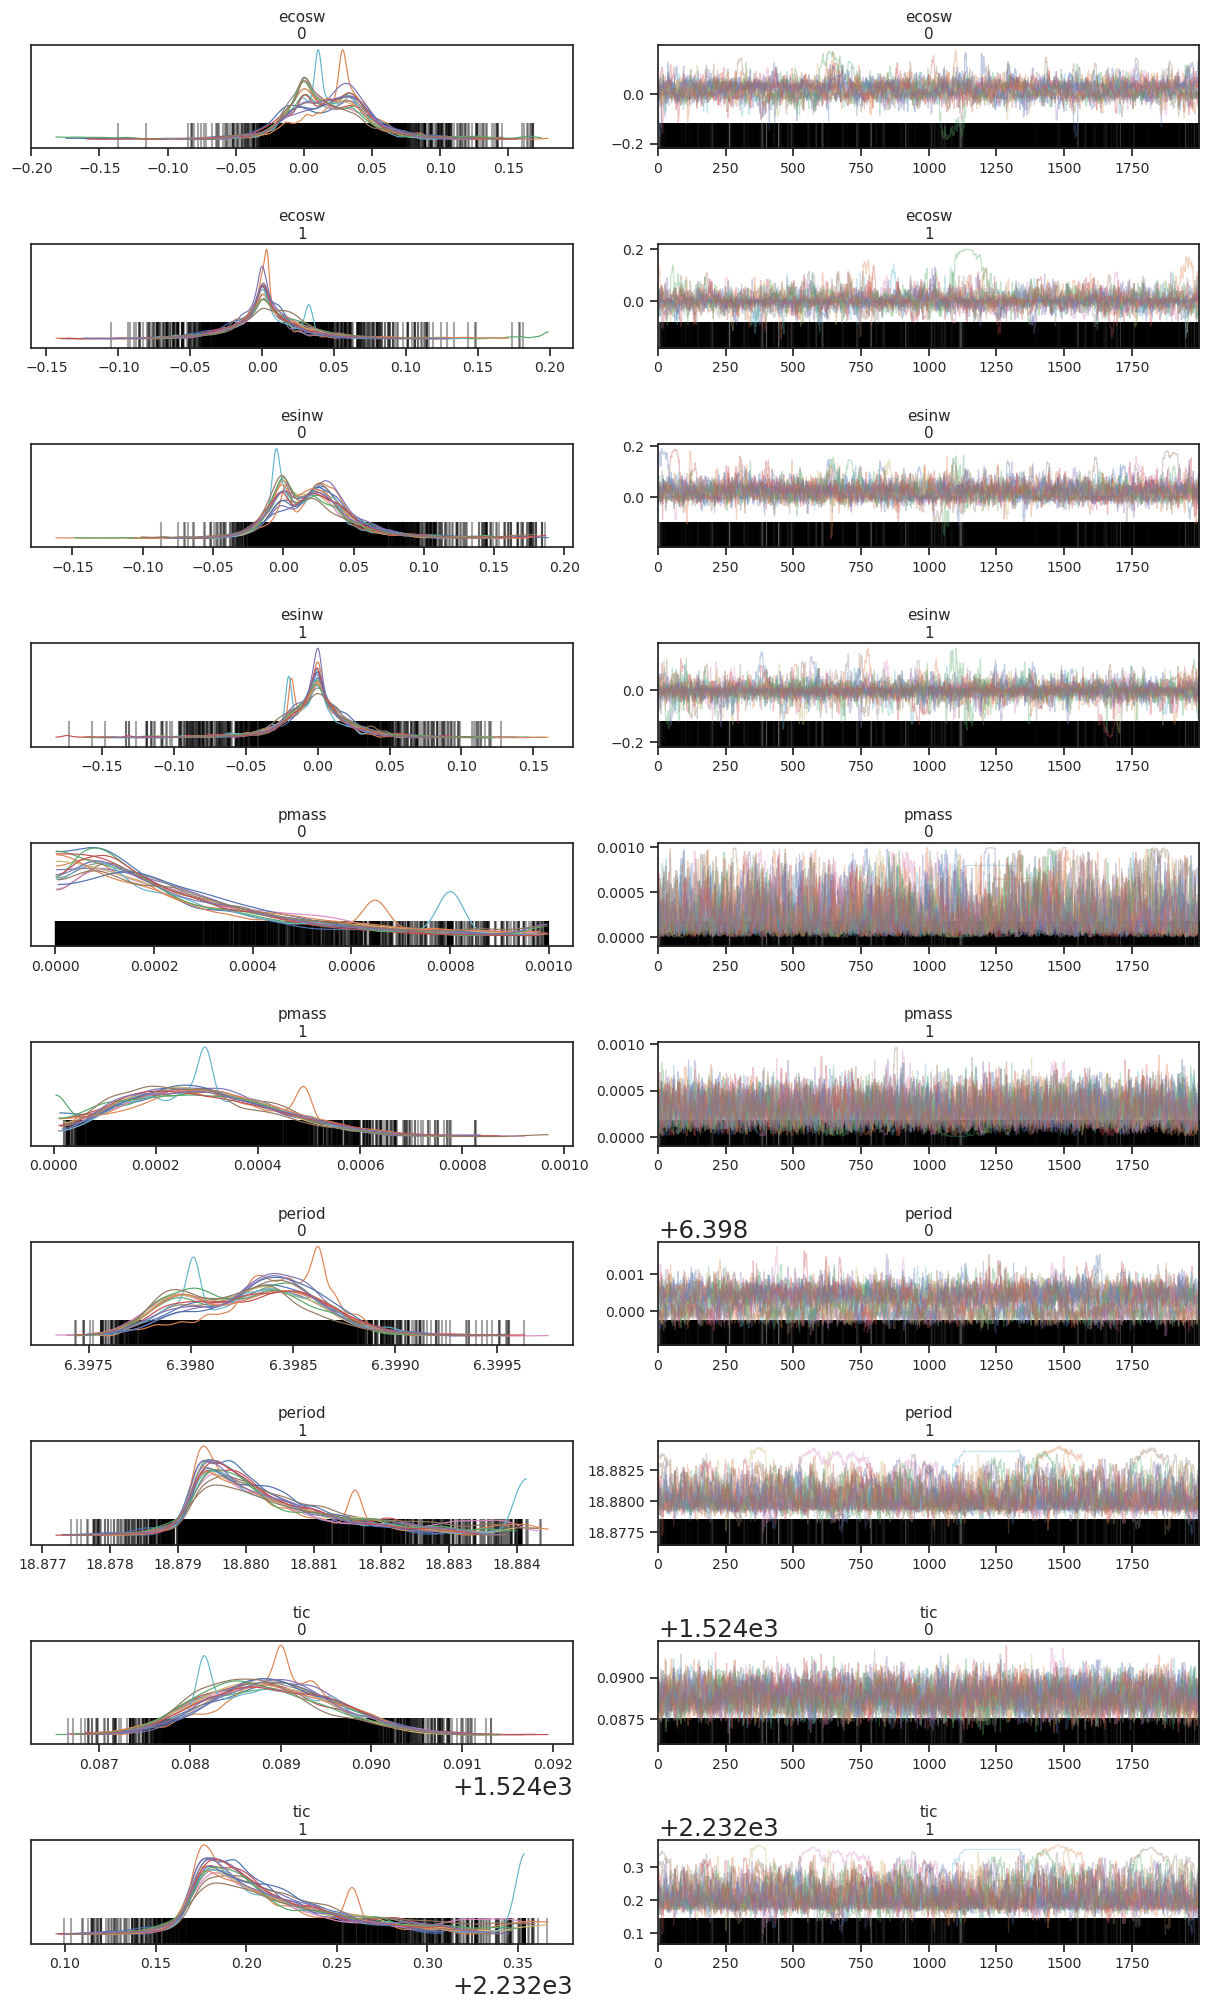

In [20]:
fig = az.plot_trace(idata, var_names=sample_keys, compact=False)
plt.tight_layout(pad=0.2)

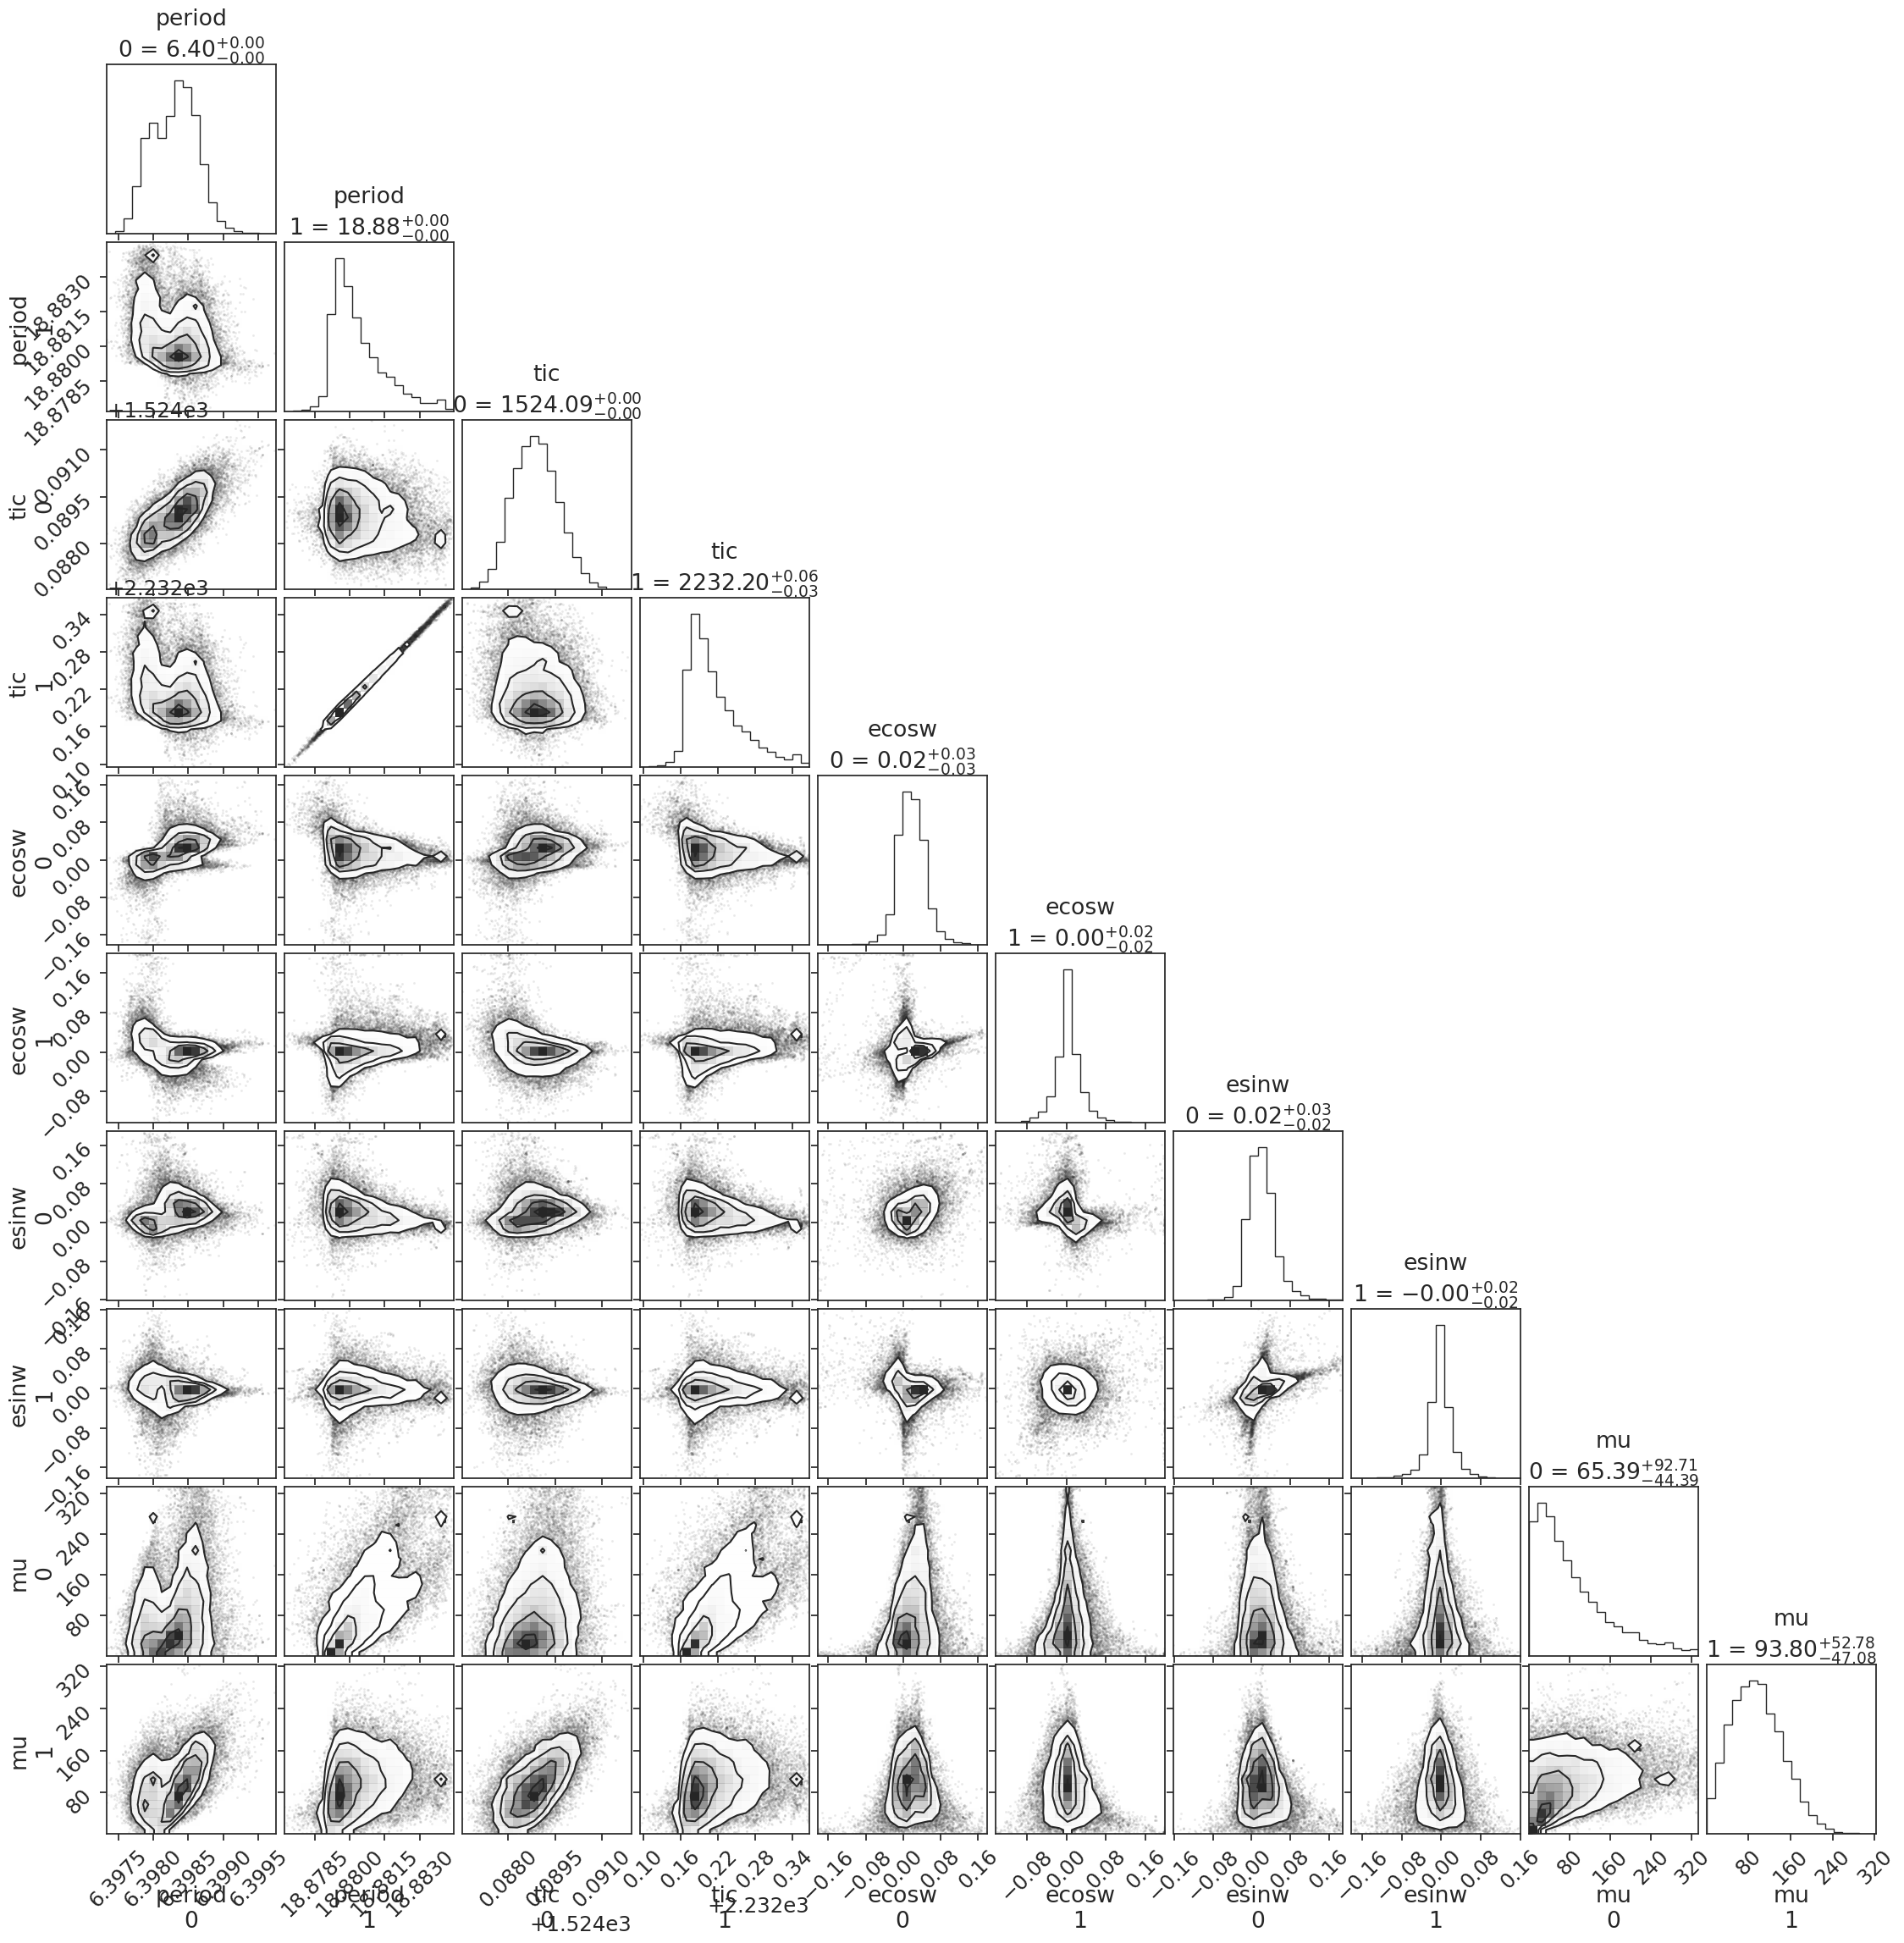

In [21]:
idata.posterior['mu'] = idata.posterior['pmass'] / 3.003e-6 # Earth mass
names = ["period", "tic", "ecosw", "esinw", "mu"]
fig = corner.corner(idata, var_names=names, show_titles=True)